Group members:


-   Ceccon Gioele - 2079425
-   Nardella Gaia
-   Renna Pietro
-   Rocca Valerio - 2094861



# Imports

In [1]:
from xml.dom import pulldom
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
import time 

# Point Generation

We decided to generate 10000 points: 


1.   5000 belong to class 1 
2.   5000 belong to class -1

In total, only 5% of the samples (equally divided among the two classes) have their true labeled assigned. 



In [29]:
n_points = 1000  # change to 10000

In [30]:
# Set up parameters for the L shape
mu1 = np.array([-2, 0])
mu2 = np.array([2, 4])
mu3 = np.array([2, 11])
mu4 = np.array([-2, 7])
sigma1 = np.array([[7, 0], [0, 0.5]])
sigma2 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 2
sigma3 = np.array([[7, 0], [0, 0.5]])
sigma4 = np.array([[0.5, 0], [0, 4]])  # Modified standard deviation for sample 4
weights = [0.25, 0.25, 0.25, 0.25]

In [31]:
# Generate random points in the L shape using the Bivariate Gaussian Mixture Distribution
samples1 = np.random.multivariate_normal(mu1, sigma1, int(n_points * weights[0]))
samples2 = np.random.multivariate_normal(mu2, sigma2, int(n_points * weights[1]))
samples3 = np.random.multivariate_normal(mu3, sigma3, int(n_points * weights[2]))
samples4 = np.random.multivariate_normal(mu4, sigma4, int(n_points * weights[3]))

In [32]:
# Assign class labels to the samples
# class1 = np.concatenate((samples2, samples1))
class1 = np.concatenate((samples2, samples1))
class1 = np.c_[class1, np.zeros(len(class1))]
count = 0
true_unlab = []
for i in class1:
    if count == 19:
        count = 0
        i[2] = 1
    else: 
      true_unlab.append(1)
    count += 1

class2 = np.concatenate((samples3, samples4))
class2 = np.c_[class2, np.zeros(len(class2))]
count = 0
for i in class2:
    if count == 19:
        count = 0
        i[2] = -1
    else: 
      true_unlab.append(-1)
    count += 1

# Combine the samples of all three classes
all_samples = np.concatenate((class1, class2))

In [33]:
# Split the samples based on their class label
unlabeled_samples = all_samples[all_samples[:, 2] == 0]
class1_samples = all_samples[all_samples[:, 2] == 1]
class2_samples = all_samples[all_samples[:, 2] == -1]

In [34]:
# Labeled matrix
labeled_samples = np.concatenate((class1_samples, class2_samples))

In [35]:
# Assign random label to unlabeled units
random_unlabeled = np.copy(unlabeled_samples)
random_unlabeled[:, 2] = np.random.choice([-1, 1], size=np.shape(unlabeled_samples)[0], p=[0.5, 0.5])

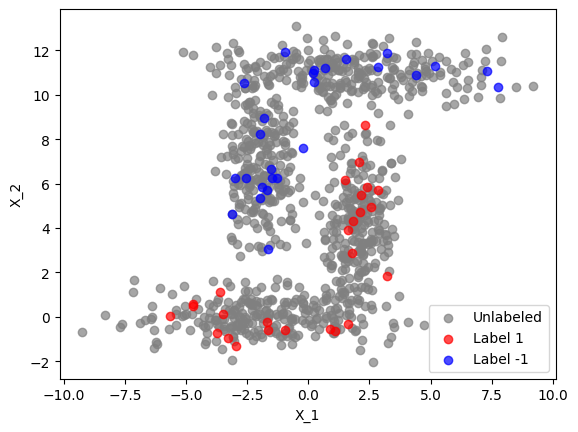

In [36]:
# Plot the samples of each class with a different color and marker
plt.scatter(unlabeled_samples[:, 0], unlabeled_samples[:, 1], color='grey', label='Unlabeled', alpha=0.7)
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.7)
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.7)

# Add legend and axis labels
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')

# Show the plot
plt.show()

# Similarity function and weights computation

Since the points are drawn from a 2D space, we choose to adopt the euclidean distance as similarity function:
$$
distance(x,y) = \|x - y\|_2
$$

In [37]:
def inverse_multiquadratic_kernel(p1, p2, c):
    """
    Computes the inverse multiquadratic kernel between two 2D points.

    Args:
    p1: A numpy array of shape (2,) containing the first 2D point.
    p2: A numpy array of shape (2,) containing the second 2D point.
    c: A scalar value that controls the strength of the kernel.

    Returns:
    A scalar value representing the inverse multiquadratic kernel between the two points.
    """
    # Compute the Euclidean distance between the points
    dist = np.sqrt(np.sum((p1 - p2) ** 2))

    # Compute the inverse multiquadratic kernel
    kernel = 1.0 / np.sqrt(dist ** 2 + c ** 2)

    return kernel

In [38]:
def min_max_normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

In [39]:
w = np.zeros((np.shape(unlabeled_samples)[0], np.shape(labeled_samples)[0]))
w_bar = np.zeros((np.shape(unlabeled_samples)[0], np.shape(unlabeled_samples)[0]))

# similarity matrix unlabeled-labeled
for row in range(np.shape(w)[0]):
    for col in range(np.shape(w)[1]):
        #w[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - labeled_samples[col, :2], ord = 2)
        w[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],labeled_samples[col, :2],0.5)

# similarity matrix unlabeled-unlabeled
for row in range(np.shape(w_bar)[0]):
    for col in range(np.shape(w_bar)[1]):
        #w_bar[row, col] = np.linalg.norm(unlabeled_samples[row, :2] - unlabeled_samples[col, :2], ord = 2)
        w_bar[row, col] = inverse_multiquadratic_kernel(unlabeled_samples[row, :2],unlabeled_samples[col, :2],0.5)

In [40]:
#w = min_max_normalize_matrix(w)
#w_bar = min_max_normalize_matrix(w_bar)

# Lipschitz constant

If f is twice continuously differentiable, then the Lipschitz constant can be estimated as the maximum eigenvalue of the Hessian matrix $\nabla^2 f$ at any point in the domain of f. Specifically, the Lipschitz constant L is given by:
$$ L = \|\nabla^2 f(x)\| $$

Thus, we can use the maximum eigenvalue of $\nabla^2 f$ to estimate L.

In this problem, the Hessian matrix is a diagonal matrix positive-definite.

In [41]:
def hessian(w=w, w_bar=w_bar):
  dim = np.shape(unlabeled_samples)[0]
  h = np.zeros((dim,dim))

  for i in range(dim):
    h[i,i] = 2 * (np.sum(w[i,:]) + np.sum(w_bar[i,:]))

  return h


In [42]:
def compute_L(hessian):
  eigenvalues = np.linalg.eigvals(hessian)
  return np.max(np.abs(eigenvalues))

In [43]:
h = hessian()
L = compute_L(h)
print(L)

634.9121290748395


# Gradient Methods

In [44]:
# Threshold selector
def threshold_sel(y_lab_norm):
    y_lab_out = np.copy(y_lab_norm)
    y_lab_out[y_lab_out < 0] = -1
    y_lab_out[y_lab_out >= 0] = 1
    return y_lab_out

## Gradient Descent

In [45]:
def gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = []
    for j in range(np.shape(unlab_samples)[0]):  # Da 0 a 947
        grad = 0
        for i in range(np.shape(lab_samples)[0]):
            grad += 2 * w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
        for i in range(np.shape(unlab_samples)[0]):
            grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
        grads.append(grad) #/ (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])) #GRADIENT+NORMALIZATION
    return np.array(grads)

In [46]:
def gradient_descent(lab_samples, unlab_samples, alpha=1/L, epochs=1000):
    #y_lab = np.copy(unlab_samples[:, 2])
    y_lab = np.copy(unlab_samples)

    y_list = []
    time_list = []

    start_time = time.time()

    for i in range(epochs):
        grads = gradient(lab_samples, y_lab)

        if np.linalg.norm(grads) < 0.00001: 
            break

        y_lab[:,2] -= alpha * grads
        

        if(i % 50 == 0):
          print(np.linalg.norm(grads))
          y_list.append(y_lab[:,2])
          elapsed_time = time.time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,2], np.array(y_list), np.array(time_list)

In [47]:
%%time
#y_lab_gd, y_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled)
y_lab_gd, y_list_gd, time_list_gd = gradient_descent(labeled_samples, unlabeled_samples)
y_lab_gd_p = threshold_sel(y_lab_gd)
print("Accuracy for Gradient Descent")
print(accuracy_score(true_unlab, y_lab_gd_p))
print("Number of 1 in Gradient Descent {}".format(np.sum(y_lab_gd_p == 1) / len(y_lab_gd_p)))
print("Number of -1 in Gradient Descent {}".format(np.sum(y_lab_gd_p == -1) / len(y_lab_gd_p)))


342.49512659537373
0.5207810036612208
0.06614646449709102
0.008401762519668678
0.0010671713745265498
0.00013554950404098755
1.7217167255421902e-05
Accuracy for Gradient Descent
0.9746835443037974
Number of 1 in Gradient Descent 0.48945147679324896
Number of -1 in Gradient Descent 0.510548523206751
CPU times: user 4min 53s, sys: 559 ms, total: 4min 53s
Wall time: 4min 57s


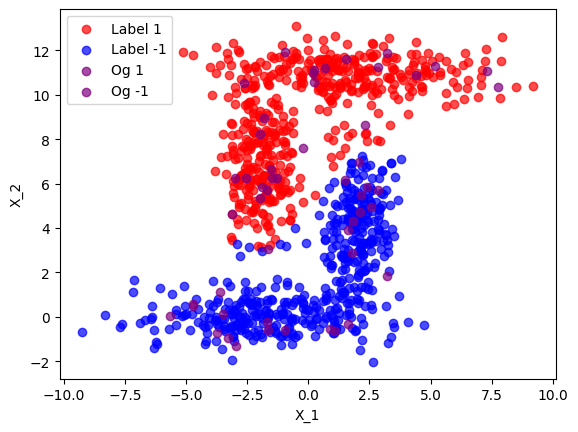

In [49]:
a = np.copy(unlabeled_samples)
result = threshold_sel(-y_lab_gd)
for i in range(len(a)):
  a[i,2] = result[i]


b = a[a[:, 2] == 1]
c = a[a[:, 2] == -1]

# Plot the samples of each class with a different color and marker
plt.scatter(b[:, 0], b[:, 1], color='red', label='Label 1', alpha=0.7)
plt.scatter(c[:, 0], c[:, 1], color='blue', label='Label -1', alpha=0.7)
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='purple', label='Og 1', alpha=0.7)
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='purple', label='Og -1', alpha=0.7)

# Add legend and axis labels
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')

# Show the plot
plt.show()



In [ ]:
accuracy_list_gd = []
for i in y_list_gd:
  i = threshold_sel(i)
  print(i)
  acc = accuracy_score(true_unlab,i)
  accuracy_list_gd.append(acc)

print(accuracy_list_gd)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

## Randomized BCGD

In [ ]:
def rand_gradient(lab_samples, unlab_samples, w=w, w_bar=w_bar):
    grads = np.zeros(np.shape(unlabeled_samples)[0])
    j = np.random.randint(0, np.shape(unlab_samples)[0])
    j = int(j)
    grad = 0
    for i in range(np.shape(lab_samples)[0]):
        grad += w[j][i] * (unlab_samples[j][2] - lab_samples[i][2])
    for i in range(np.shape(unlab_samples)[0]):
        grad += w_bar[j][i] * (unlab_samples[j][2] - unlab_samples[i][2])
    grads[j] = 2 * grad  # / (np.shape(lab_samples)[0] + np.shape(unlab_samples)[0])
    return grads

In [ ]:
def rand_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=1000):
    y = np.copy(unlab_samples)

    for _ in range(epochs):
        grads = rand_gradient(lab_samples, y)

        if np.linalg.norm(grads) < 0.001: 
            break

        y[:, 2] -= alpha * grads

    y_lab = np.copy(y[:, 2])

    return y_lab

In [ ]:
y_lab_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled)
y_lab_rand_bcgd_p = threshold_sel(y_lab_rand_bcgd)
print("Accuracy for Randomized BCGD")
print(accuracy_score(true_unlab, y_lab_rand_bcgd_p))
print("Frequency of 1 in Randomized BCGD {}".format(np.sum(y_lab_rand_bcgd_p == 1) / len(y_lab_rand_bcgd_p)))
print("Frequency of -1 in Randomized BCGD {}".format(np.sum(y_lab_rand_bcgd_p == -1) / len(y_lab_rand_bcgd_p)))


Accuracy for Randomized BCGD
0.48945147679324896
Frequency of 1 in Randomized BCGD 0.2552742616033755
Frequency of -1 in Randomized BCGD 0.7447257383966245


## Gauss-Southwell BCDG

In [ ]:
def max_gradient(lab_samples, unlab_samples):
    grad = gradient(lab_samples, unlab_samples)
    j = np.argmax(np.abs(gradient(lab_samples, unlab_samples)))
    grads = np.zeros(np.shape(unlabeled_samples)[0])
    grads[j] = grad[j]
    return grads

In [ ]:
def gs_bcgd(lab_samples, unlab_samples, alpha=1/L, epochs=1000):
    y = np.copy(unlab_samples)

    for _ in range(epochs):
        grads = max_gradient(lab_samples, y)

        if np.linalg.norm(grads) < 0.001: 
            break

        y[:, 2] -= alpha * grads

    y_lab = np.copy(y[:, 2])

    return y_lab

In [ ]:
y_lab_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled)
y_lab_gs_bcgd_p = threshold_sel(y_lab_gs_bcgd)
print("Accuracy for Gauss Sauthwell BCGD")
print(accuracy_score(true_unlab, y_lab_gs_bcgd_p))

print("Frequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(y_lab_gs_bcgd_p == 1) / len(y_lab_gs_bcgd_p)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}".format(np.sum(y_lab_gs_bcgd_p == -1) / len(y_lab_gs_bcgd_p)))

print(prova == y_lab_gs_bcgd_p)

Accuracy for Gauss Sauthwell BCGD
0.4957805907172996
Frequency of 1 in Gauss Sauthwell BCGD 0.4578059071729958
Frequency of -1 in Gauss Sauthwell BCGD 0.5421940928270043
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T